In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
import tensorflow as tf
import skimage.filters
import random
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
#Список изображений и классов
path_list = sorted(glob.glob('/tf/notebooks/data/cifar10/images/*'))
images_list=[]   
images_class=[]


#Так как будем используем простую модель, уменьшим количество классов до 3
for i, val in enumerate(path_list[0:3]):
    #print(i)
    images_one_class_list= val + "/*.png"
    
    images_one_class_list = sorted(glob.glob(images_one_class_list))
    
    images_list += images_one_class_list
    images_class += [i]*len(images_one_class_list)

In [3]:
#Функция для загрузки изображения
def load_img_one(image):

    #Загружаем и препроцессим изображения
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (32,32))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    return image

def load_img(x, y):
    x_new = load_img_one(x)
    return x_new, y

In [4]:
def batch_img_gen(in_df, batch_size):
    out_x, out_y = [], []
    while True:
        for c_df in np.random.permutation(in_df):

            x, y = load_img(c_df[0], c_df[1])
            out_x += [x]
            out_y += [y]

            if len(out_x) >= batch_size:
                yield np.stack(out_x, 0), np.stack(out_y, 0)
                out_x, out_y = [], []


In [5]:
full_df = pd.DataFrame()
full_df["path"] = images_list
full_df["class"]= images_class

In [6]:
x_train, x_test, y_train, y_test = train_test_split(full_df["path"], full_df["class"], train_size = 0.7)

train_df = pd.DataFrame()
test_df = pd.DataFrame()
train_df['x'] = x_train.values
train_df['y'] = y_train.values

test_df['x'] = x_test.values
test_df['y'] = y_test.values


In [7]:
BATCH_SIZE = 64
train_batches = batch_img_gen(train_df, BATCH_SIZE)
test_batches  = batch_img_gen(test_df, BATCH_SIZE)


In [10]:
MARGIN = 20.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [11]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [12]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [13]:
%%time

NUM_ITER = 6000
for iteration, (images, labels) in enumerate(train_batches):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
    
    if iteration > NUM_ITER:
        break


[0] Loss: 334.1112060546875
[200] Loss: 55.720497131347656
[400] Loss: 77.84150695800781
[600] Loss: 58.16925048828125
[800] Loss: 47.76819610595703
[1000] Loss: 37.89668273925781
[1200] Loss: 33.09282302856445
[1400] Loss: 13.361945152282715
[1600] Loss: 17.78998565673828
[1800] Loss: 8.21575927734375
[2000] Loss: 4.531723976135254
[2200] Loss: 2.45355224609375
[2400] Loss: 2.14174747467041
[2600] Loss: 1.5815247297286987
[2800] Loss: 1.4570467472076416
[3000] Loss: 1.8025729656219482
[3200] Loss: 2.192502021789551
[3400] Loss: 2.2890450954437256
[3600] Loss: 0.9134016633033752
[3800] Loss: 2.0544402599334717
[4000] Loss: 1.4800504446029663
[4200] Loss: 2.179591655731201
[4400] Loss: 1.8132538795471191
[4600] Loss: 3.4374687671661377
[4800] Loss: 2.011078119277954
[5000] Loss: 0.5819599628448486
[5200] Loss: 0.9337859153747559
[5400] Loss: 0.34637612104415894
[5600] Loss: 1.841321587562561
[5800] Loss: 1.0344609022140503
[6000] Loss: 1.582400918006897
CPU times: user 4min 17s, sys: 8.

In [14]:
def batch_img_gen_one(in_df, batch_size):
    out_x, out_y = [], []
    
    for c_df in np.array(in_df):

        x, y = load_img(c_df[0], c_df[1])
        out_x += [x]
        out_y += [y]

        if len(out_x) >= batch_size:
            yield np.stack(out_x, 0), np.stack(out_y, 0)
            out_x, out_y = [], []


In [23]:
len(test_df)

904

In [16]:
test_batches = batch_img_gen_one(test_df, batch_size = 900)

In [17]:

test_embs = []
for iteration, (images, labels) in enumerate(test_batches):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        test_embs.append(embs)
#     if iteration > NUM_ITER:
#         break

In [18]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [22]:
len(test_embs[0])

900

In [ ]:
#y_test[:500]

In [20]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[0][:900])
labels_for_viz = y_test[:900]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
<ipython-input-20-db629c2d16ac>:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  labels_for_viz = y_test[:900]


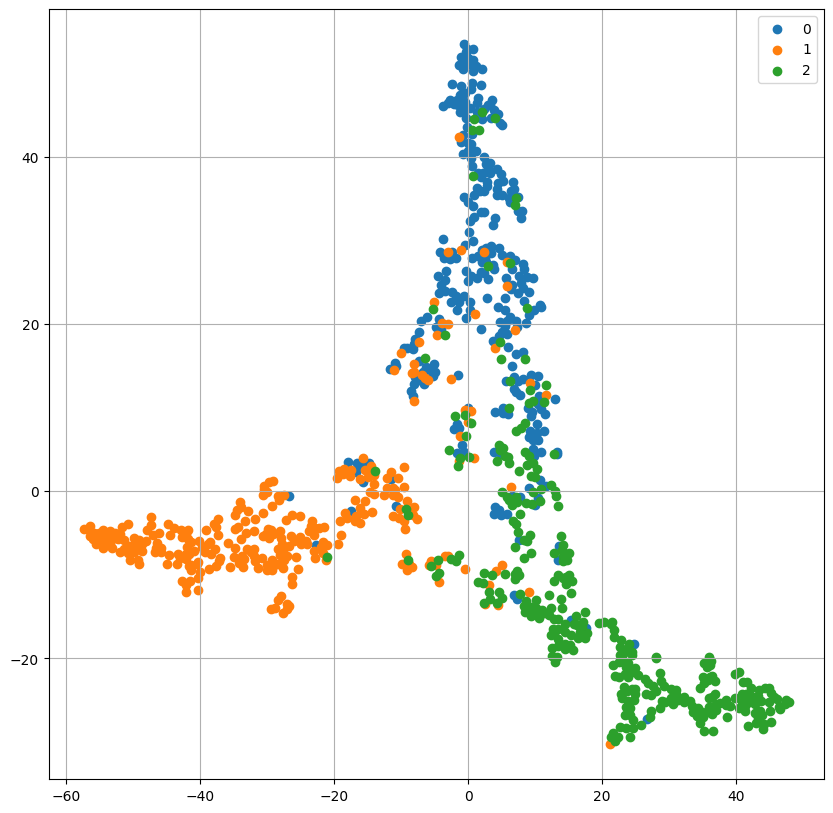

In [21]:
draw_embeddings(test_embs_2D, labels_for_viz, list(range(3)))